Περιλαμβάνουμε αρχικά την συνάρτηση interest_points_visualization για την οπτικοποίηση των γωνιών που ανιχνεύονται.

In [1]:
def fspecial_log(p2, std):
    siz = int((p2-1)/2)
    x = y = np.linspace(-siz, siz, 2*siz+1)
    x, y = np.meshgrid(x, y)
    arg = -(x**2 + y**2) / (2*std**2)
    h = np.exp(arg)
    h1 = h*(x**2 + y**2 - 2*std**2) / (std**4)
    return h1

In [109]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def interest_points_visualization(I_, kp_data_, title, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    
    plt.title(title)
    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(circ)

    return ax

def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

Επισυνάπτουμε τις 5 μεθόδους που αναλύθηκαν στο δεύτερο μέρος της εργασίας σε μορφή συναρτήσεων. Κάθε μία από αυτές τις συναρτήσεις θα επιστρέφει τον Νx3 πίνακα με τις ανιχνευθείσες γωνίες που θα μας χρειαστεί για το 3ο μέρος.

## 1η μέθοδος Harris-Stephens

In [3]:
N = 4
sigma = 2
r = 2.5
k = 0.05
u_corn = 0.005
s = 1.5

In [4]:
def HarrisStephens(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005):
    n = int(np.ceil(3*sigma))*2 + 1
    Gs = cv2.getGaussianKernel(n, sigma)
    Gr = cv2.getGaussianKernel(n, r)
    Is = cv2.filter2D(img,-1,Gs)
    dIs = np.gradient(Is)
    J1 = cv2.filter2D(np.multiply(dIs[0], dIs[0]),-1,Gr)
    J2 = cv2.filter2D(np.multiply(dIs[0], dIs[1]),-1,Gr)
    J3 = cv2.filter2D(np.multiply(dIs[1], dIs[1]),-1,Gr)
    D = np.sqrt(np.square(J1-J3)+4*np.square(J2))
    l_plus = (J1 + J3 + D) / 2
    l_minus = (J1 + J3 - D) / 2
    R = np.multiply(l_plus, l_minus) - k*np.square(l_minus + l_plus)
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    R_max = np.max(R)
    Cond2 = np.where(R>u_corn*R_max, 1, 0)
    Cond = Cond1&Cond2
    points=np.sum(Cond==True)
    scale = np.zeros(points)
    scale.fill(sigma)
    num_of_points=scale.shape[0]
    N2 = np.zeros((num_of_points, 2))
    a = np.where(Cond==1)
    for j in range(len(a[0])):
        N2[j,1]=a[0][j]
        N2[j,0]=a[1][j]
    scale = np.expand_dims(scale, axis=1)
    return np.concatenate((N2, scale), axis=1)

In [5]:
import cv2

sun = cv2.imread('../sunflowers.png', cv2.IMREAD_GRAYSCALE)

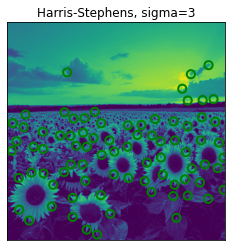

In [110]:
inp = HarrisStephens(sun, sigma=3)
interest_points_visualization(sun, inp, 'Harris-Stephens, sigma=3')

## 2η μέθοδος Harris Laplacian

In [7]:
def HarrisLaplacian(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005, N=4, s=1.5):
    sigmas = [sigma*(s**i) for i in range(N)]
    
    ind = {k: v for v, k in enumerate(sigmas)}
    
    rs = [r*(s**i) for i in range(N)]
    Angles = [HarrisStephens(img, sigmas[i], rs[i]) for i in range(N)]
    LoGs = [np.abs(fspecial_log(int(np.ceil(3*x))*2 + 1,x))*(x**2) for x in sigmas]
    Ls = [cv2.filter2D(img,-1,LoGs[i]) for i in range(N)]
    total = np.zeros((0,3))
    indices=np.zeros((0))
    total = np.vstack(Angles)
    deletion=[]
    count=0
    for a in total:
        x, y, si = a
        x = int(x)
        y = int(y)
        pos=ind[si]
        if pos==0:
            if Ls[pos+1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        elif pos==N-1:
            if Ls[pos-1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        else:
            if Ls[pos+1][y,x]>=Ls[pos][y,x] and Ls[pos-1][y,x]>=Ls[pos][y,x]:
                deletion.append(count)
        count+=1
    return np.delete(total, deletion, 0)

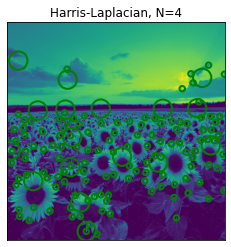

In [111]:
inp=HarrisLaplacian(sun, N=4)
interest_points_visualization(sun, inp, 'Harris-Laplacian, N=4')

## 3η μέθοδος Βlobs

In [9]:
def Blobs(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005):
    n = int(np.ceil(3*sigma))*2 + 1
    Gs = cv2.getGaussianKernel(n, sigma)
    Gr = cv2.getGaussianKernel(n, r)
    Is = cv2.filter2D(img,-1,Gs)
    Lx, Ly = np.gradient(Is)
    Lxx, Lxy = np.gradient(Lx)
    Lyx, Lyy = np.gradient(Ly)
    CriterionR = np.multiply(Lxx, Lyy) - np.multiply(Lxy, Lyx)
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = ( CriterionR==cv2.dilate(CriterionR,B_sq) )
    R_max = np.max(CriterionR)
    Cond2 = np.where(CriterionR>u_corn*R_max, 1, 0)
    Cond = Cond1&Cond2
    points = np.sum(Cond==True)
    scale = np.zeros(points)
    scale.fill(sigma)
    num_of_points=scale.shape[0]
    N2 = np.zeros((num_of_points, 2))
    a = np.where(Cond==1)
    for j in range(len(a[0])):
        N2[j,1]=a[0][j]
        N2[j,0]=a[1][j]
    scale = np.expand_dims(scale, axis=1)
    return np.concatenate((N2, scale), axis=1)

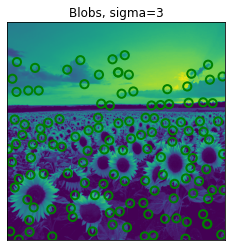

In [112]:
inp = Blobs(sun, sigma=3)
interest_points_visualization(sun, inp, 'Blobs, sigma=3')

## 4η μέθοδος Multiscale Blobs

In [11]:
def MultiscaleBlobs(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005, N=4, s=1.5):
    sigmas = [sigma*(s**i) for i in range(N)]
    
    ind = {k: v for v, k in enumerate(sigmas)}
    
    rs = [r*(s**i) for i in range(N)]
    Angles = [Blobs(img, sigmas[i], rs[i]) for i in range(N)]
    LoGs = [np.abs(fspecial_log(int(np.ceil(3*x))*2 + 1,x))*(x**2) for x in sigmas]
    Ls = [cv2.filter2D(img,-1,LoGs[i]) for i in range(N)]
    total = np.zeros((0,3))
    indices=np.zeros((0))
    total = np.vstack(Angles)
    deletion=[]
    count=0
    for a in total:
        x, y, si = a
        x = int(x)
        y = int(y)
        pos=ind[si]
        if pos==0:
            if Ls[pos+1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        elif pos==N-1:
            if Ls[pos-1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        else:
            if Ls[pos+1][y,x]>=Ls[pos][y,x] and Ls[pos-1][y,x]>=Ls[pos][y,x]:
                deletion.append(count)
        count+=1
    return np.delete(total, deletion, 0)

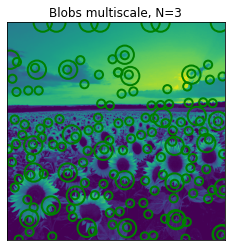

In [113]:
inp = MultiscaleBlobs(sun, sigma=3, N=3)
interest_points_visualization(sun, inp, 'Blobs multiscale, N=3')

## 5η μέθοδος Box Filters

In [13]:
def BoxFilters(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005):
    n = int(np.ceil(3*sigma)*2+1)
    
    Dxx = np.zeros((n,n))
    Dxy = np.zeros((n,n))

    q = int(np.floor(n/6))
    small=int(2*np.floor(n/6)+1)
    big=int(4*np.floor(n/6)+1)

    Dxx[((n//2+1)-q):((n//2+1)+q), :small]=1
    Dxx[((n//2+1)-q):((n//2+1)+q), small+1:2*small+1]=-2
    Dxx[((n//2+1)-q):((n//2+1)+q), 2*small+1:3*small+1]=1

    Dyy = np.transpose(Dxx)

    middle=n//2+1
    Dxy[middle-1-small:middle-1,middle-1-small:middle-1]=1
    Dxy[middle:middle+small,middle:middle+small]=1
    Dxy[middle-1-small:middle-1,middle:middle+small]=-1
    Dxy[middle:middle+small,middle-1-small:middle-1]=-1

    Lxx = cv2.filter2D(img ,-1, Dxx)
    Lxy = cv2.filter2D(img ,-1, Dxy)
    Lyy = cv2.filter2D(img ,-1, Dyy)

    CriterionR = np.multiply(Lxx, Lyy) - 0.81*np.multiply(Lxy, Lxy)
    
    B_sq = disk_strel(n)
    C1 = ( CriterionR==cv2.dilate(CriterionR,B_sq) )

    R_max = np.max(CriterionR)
    C2 = np.where(CriterionR>u_corn*R_max, 1, 0)

    Cond = C1&C2
    points = np.sum(Cond==True)
    scale = np.zeros(points)
    scale.fill(sigma)
    num_of_points=scale.shape[0]
    N2 = np.zeros((num_of_points, 2))
    a = np.where(Cond==1)
    for j in range(len(a[0])):
        N2[j,1]=a[0][j]
        N2[j,0]=a[1][j]
    scale = np.expand_dims(scale, axis=1)
    return np.concatenate((N2, scale), axis=1)

def MultiBoxFilters(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005, N=4, s=1.5):
    
    sigmas = [sigma*(s**i) for i in range(N)]
    ind = {k: v for v, k in enumerate(sigmas)}
    rs = [r*(s**i) for i in range(N)]
    Angles = [BoxFilters(img, sigmas[i], rs[i]) for i in range(len(sigmas))]
    LoGs = [np.abs(fspecial_log(int(np.ceil(3*x))*2 + 1,x))*(x**2) for x in sigmas]
    Ls = [cv2.filter2D(img,-1,LoGs[i]) for i in range(N)]
    total = np.zeros((0,3))
    indices=np.zeros((0))
    total = np.vstack(Angles)
    deletion=[]
    count=0
    for a in total:
        x, y, si = a
        x = int(x)
        y = int(y)
        pos=ind[si]
        if pos==0:
            if Ls[pos+1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        elif pos==N-1:
            if Ls[pos-1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        else:
            if Ls[pos+1][y,x]>=Ls[pos][y,x] and Ls[pos-1][y,x]>=Ls[pos][y,x]:
                deletion.append(count)
        count+=1
    return np.delete(total, deletion, 0)

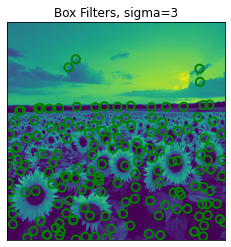

In [114]:
inp = BoxFilters(sun, sigma=3)
interest_points_visualization(sun, inp, 'Box Filters, sigma=3')

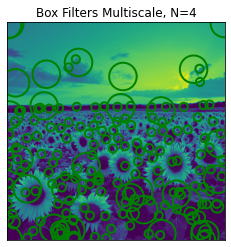

In [115]:
inp = MultiBoxFilters(sun, sigma=3, N=4)
interest_points_visualization(sun, inp, 'Box Filters Multiscale, N=4')

# 3o Μέρος

## 3.1. Ταίριασμα Εικόνων υπό Περιστροφή και Αλλαγή Κλίμακας

In [16]:
import cv20_lab1_part3_utils

Συλλέγουμε τα δεδομένα για όλους τους πιθανούς συνδυασμούς σε έναν πίνακα 5x2.

In [44]:
import cv20_lab1_part3_utils as p3

# Here is a lambda which acts as a wrapper for detector function, e.g. harrisDetector.
# The detector arguments are, in order: image, sigma, rho, k, threshold.
detect_fun=[]
detect_fun.append(lambda I: HarrisStephens(I, 2, 2.5, 0.05, 0.005))
detect_fun.append(lambda I: HarrisLaplacian(I, 2, 2.5, 0.05, 0.005))
detect_fun.append(lambda I: Blobs(I, 2, 2.5, 0.05, 0.005))
detect_fun.append(lambda I: MultiscaleBlobs(I, 2, 2.5, 0.05, 0.005))
detect_fun.append(lambda I: MultiBoxFilters(I, 2, 2.5, 0.05, 0.005))

# You can use either of the following lines to extract features (HOG/SURF).
desc_fun=[]
desc_fun.append(lambda I, kp: p3.featuresSURF(I,kp))
desc_fun.append(lambda I, kp: p3.featuresHOG(I,kp))

In [22]:
thetas = np.zeros((5,2,3))
scales = np.zeros((5,2,3))

for i in range(5):
    for j in range(2):
        scales[i,j,:], thetas[i,j,:] = p3.matching_evaluation(detect_fun[i], desc_fun[j])

C:\Users\ΓΙΑΝΝΗΣ\Desktop\οραση\lab1\cv20_lab1_part3_material\cv20_lab1_part3_utils.py:220: RuntimeWarning: invalid value encountered in double_scalars


In [38]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Harris-Stephens', 'Harris-Laplacian', 'Blobs', 'Multiscale Blobs', 'Multiscale Box Filters']

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

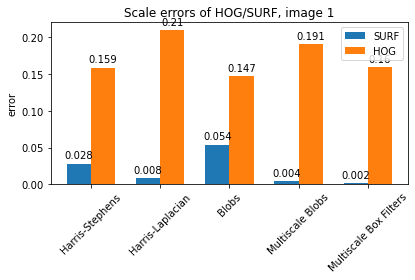

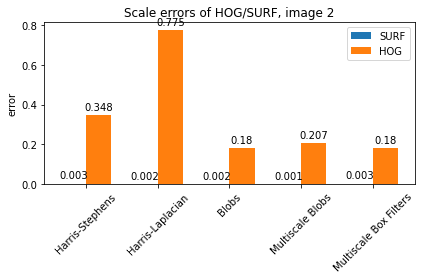

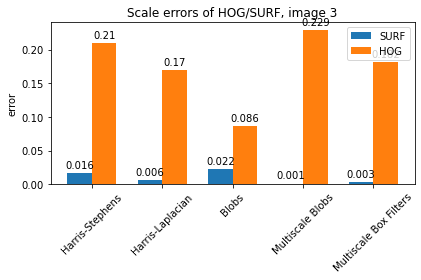

In [39]:
for i in range(3):
    SURF = np.round(scales[:,0,i],3)
    HOG = np.round(scales[:,1,i], 3)
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, SURF, width, label='SURF')
    rects2 = ax.bar(x + width/2, HOG, width, label='HOG')
    ax.set_ylabel('error')
    ax.set_title('Scale errors of HOG/SURF, image '+str(i+1))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks(rotation=45)
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

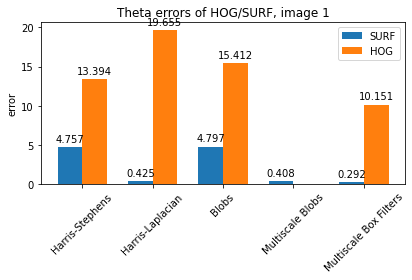

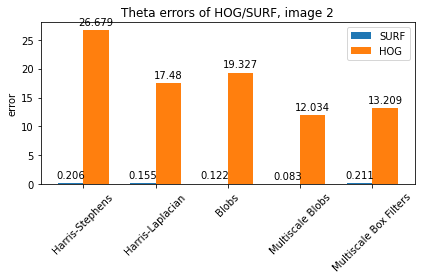

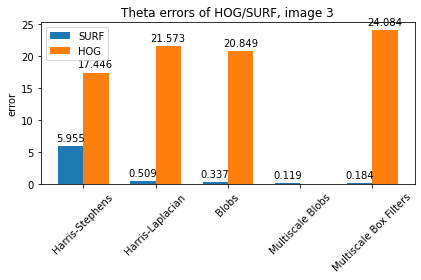

In [40]:
for i in range(3):
    SURF = np.round(thetas[:,0,i],3)
    HOG = np.round(thetas[:,1,i], 3)
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, SURF, width, label='SURF')
    rects2 = ax.bar(x + width/2, HOG, width, label='HOG')
    ax.set_ylabel('error')
    ax.set_title('Theta errors of HOG/SURF, image '+str(i+1))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks(rotation=45)
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

## 3.2. Κατηγοριοποίηση Εικόνων

### 3.2.1

In [45]:
# Extract features from the provided dataset.
feats = p3.FeatureExtraction(detect_fun[4], desc_fun[0])

# If the above code takes too long, you can use the following extra parameters of Feature extraction:
#   saveFile = <filename>: Save the extracted features in a file with the provided name.
#   loadFile = <filename>: Load the extracted features from a given file (which MUST exist beforehand).

Time for feature extraction: 229.870


In [58]:
feats[0][111].shape

(84, 64)

In [54]:
accs = []
for k in range(5):
    # Split into a training set and a test set.
    data_train, label_train, data_test, label_test = p3.createTrainTest(feats, k)

    # Perform Kmeans to find centroids for clusters.
    BOF_tr, BOF_ts = p3.BagOfWords(data_train, data_test)

    # Train an svm on the training set and make predictions on the test set
    acc, preds, probas = p3.svm(BOF_tr, label_train, BOF_ts, label_test)
    accs.append(acc)

print('Mean accuracy for MultiBox with SURF descriptors: {:.3f}%'.format(100.0*np.mean(accs)))

Mean accuracy for MultiBox with SURF descriptors: 59.034%


In [76]:
data_train[10].shape

(89, 64)

Χρησιμοποιούμε τον kmeans του sklearn:

In [69]:
from sklearn.cluster import KMeans

total_clusters=1000
kmeans = KMeans(n_clusters = total_clusters)

Στοιβάζουμε όλους του περιγραφητές όλων των εικόνων ώστε να πάρουμε ένα σύνολο σειρών κάθε μία από τις οποίες θα έχει το ίδιο μέγεθος.

In [77]:
d_tr=np.vstack(data_train)
print(d_tr.shape)

(27089, 64)


Επιλέγουμε τις μισές από αυτές.

In [81]:
d_tr_sample=d_tr[np.random.choice(d_tr.shape[0], len(d_tr)//2, replace=False)]

Εκπαιδεύουμε με τα δεδομένα μας το μοντέλο ώστε να βρούμε τα κέντρα.

In [82]:
kmeans.fit(d_tr_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1000, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [86]:
kmeans.cluster_centers_.shape

(1000, 64)

Τέλος για τα σύνολα εκπαίδευσης και τεστ παίρνουμε κάθε εικόνα, και για κάθε ένα από τα χαρακτηριστικά της υπολογίζουμε το κέντρο από το οποίο απέχει λιγότερο. Ύστερα φτιάχνουμε ένα ιστόγραμμα από αυτές τις τιμές το οποίο θα εκπροσωπεί την εικόνα. Με βάση αυτές τις αραιές παραστάσεις που θα προκύψουν εκτελούμε τη συνάρτηση svm.

In [99]:
import torch

hist_train=[]
hist_test=[]

for i in data_train:
    clusts = []
    for j in i:
        distances=[]
        for k in kmeans.cluster_centers_:
            distances.append(np.linalg.norm(j-k))
        clusts.append(distances.index(min(distances)))
    temp = np.histogram(clusts, bins=range(total_clusters))[0] 
    hist_train.append(temp / np.linalg.norm(temp))
    
for i in data_test:
    clusts = []
    for j in i:
        distances=[]
        for k in kmeans.cluster_centers_:
            distances.append(np.linalg.norm(j-k))
        clusts.append(distances.index(min(distances)))
    temp = np.histogram(clusts, bins=range(total_clusters))[0] 
    hist_test.append(temp / np.linalg.norm(temp))

In [100]:
acc, preds, probas = p3.svm(hist_train, label_train, hist_test, label_test)

In [101]:
acc

0.6482758620689655

Για τους 6 πιθανούς συνδυασμόυς ανιχνευτών / περιγραφητών (3 multiscale ανιχνευτές x 2 περιγραφήτες) εκτελούμε την εκπαίδευση με την έτοιμη συνάρτηση όπως και με την παραπάνω διαδικασία που υλοποιήθηκε και συγκρίνουμε τις αποδόσεις accuracy σε ένα διάγραμμα.

In [103]:
ready=np.zeros(6)
implement=np.zeros(6)
for count, ii in enumerate([1,3,4]):
    for jj in range(2):
        feats = p3.FeatureExtraction(detect_fun[ii], desc_fun[jj])
        accs = []
        for k in range(5):
            # Split into a training set and a test set.
            data_train, label_train, data_test, label_test = p3.createTrainTest(feats, k)

            # Perform Kmeans to find centroids for clusters.
            BOF_tr, BOF_ts = p3.BagOfWords(data_train, data_test)

            # Train an svm on the training set and make predictions on the test set
            acc, preds, probas = p3.svm(BOF_tr, label_train, BOF_ts, label_test)
            accs.append(acc)
        ready[3*jj+count]=100.0*np.mean(accs)
        
        accs=[]
        for k in range(3):
            total_clusters=1000
            kmeans = KMeans(n_clusters = total_clusters)
            d_tr=np.vstack(data_train)
            d_tr_sample=d_tr[np.random.choice(d_tr.shape[0], len(d_tr)//2, replace=False)]
            kmeans.fit(d_tr_sample)
            
            hist_train=[]
            hist_test=[]

            for i in data_train:
                clusts = []
                for j in i:
                    distances=[]
                    for k in kmeans.cluster_centers_:
                        distances.append(np.linalg.norm(j-k))
                    clusts.append(distances.index(min(distances)))
                temp = np.histogram(clusts, bins=range(total_clusters))[0] 
                hist_train.append(temp / np.linalg.norm(temp))

            for i in data_test:
                clusts = []
                for j in i:
                    distances=[]
                    for k in kmeans.cluster_centers_:
                        distances.append(np.linalg.norm(j-k))
                    clusts.append(distances.index(min(distances)))
                temp = np.histogram(clusts, bins=range(total_clusters))[0] 
                hist_test.append(temp / np.linalg.norm(temp))
                
            acc, preds, probas = p3.svm(hist_train, label_train, hist_test, label_test)
            accs.append(acc)
        implement[3*jj+count]=100.0*np.mean(accs)

Time for feature extraction: 207.794
Time for feature extraction: 223.987
Time for feature extraction: 193.489
Time for feature extraction: 230.117
Time for feature extraction: 27526.510
Time for feature extraction: 258.230


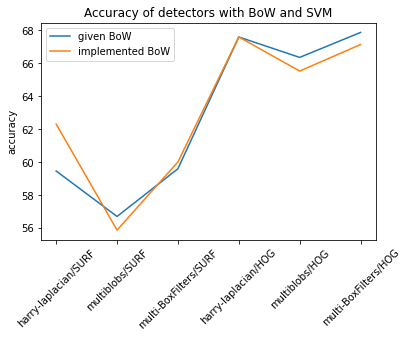

In [105]:
fig, ax = plt.subplots()

x = ['harry-laplacian/SURF', 'multiblobs/SURF', 'multi-BoxFilters/SURF', 'harry-laplacian/HOG', 
     'multiblobs/HOG', 'multi-BoxFilters/HOG']

ax.plot(x, ready, label="given BoW")
ax.plot(x, implement, label="implemented BoW")
ax.legend()

plt.title('Accuracy of detectors with BoW and SVM')
plt.xticks(rotation=45)

plt.ylabel('accuracy')
plt.show()